In [9]:
import math
import matplotlib.pyplot as plt
plt.ion()

def show_images(images, make_random=False, fig_title='Default title', CMAP=None):
    count = len(images)
    col_count = 5
    rows = math.ceil(float(len(images)) / float(col_count))
    fig = plt.figure(figsize=(4*int(col_count),2*rows))
    fig.suptitle(fig_title, fontsize=16)
    
    for i in range(count):
        image = images[i]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax1 = fig.add_subplot(rows,col_count,i+1)
        #ax1.set_title(labelssamples[i] + ' occurences', fontsize=8)
        ax1.imshow(image, cmap=CMAP)
        #cv2.imwrite("./samples/" + str(fig_title) + "_" + str(i) + ".png", image)
    #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
def get_average_bbox(bbox, prev_n_bb_list_list, img):
    bboxes_to_consider = [bbox]
    
    for prev_bbox_list in prev_n_bb_list_list:
        matched_bbox = bb_intersection_over_union(bbox, prev_bbox_list)
        if matched_bbox != None and matched_bbox != True:
            bboxes_to_consider.append(matched_bbox)
            
        
    # Take avg
    mean_bbox =\
        ((( int(np.mean([x1 for ((x1, y1), (x2, y2)) in bboxes_to_consider])) ), int(np.mean([y1 for ((x1, y1), (x2, y2)) in bboxes_to_consider])) ),
         (( int(np.mean([x2 for ((x1, y1), (x2, y2)) in bboxes_to_consider]) )), int(np.mean([y2 for ((x1, y1), (x2, y2)) in bboxes_to_consider])) ))
    
    return mean_bbox
        
def bb_intersect(boxA, boxB):
    return not (boxA[1][0] < boxB[0][0] or boxA[0][0] > boxB[1][0] or boxA[1][1] < boxB[0][1] or boxA[0][1] > boxB[1][1])
    
def bb_intersection_over_union(boxA, boxB_list):
    if not boxB_list or len(boxB_list) == 0:
        return True
    
    best_bbox = None
    prev_best_iou = -100000000.0
    boxAArea = (boxA[1][0] - boxA[0][0] + 1) * (boxA[1][1] - boxA[0][1] + 1)
    for boxB in boxB_list:
        if boxAArea < 2000 or not bb_intersect(boxA, boxB):
            continue
        
        # determine the (x, y)-coordinates of the intersection rectangle
        xA = max(boxA[0][0], boxB[0][0])
        yA = max(boxA[0][1], boxB[0][1])
        xB = min(boxA[1][0], boxB[1][0])
        yB = min(boxA[1][1], boxB[1][1])

        # compute the area of intersection rectangle
        interArea = (xB - xA + 1) * (yB - yA + 1)

        # compute the area of both the prediction and ground-truth
        # rectangles
        boxAArea = (boxA[1][0] - boxA[0][0] + 1) * (boxA[1][1] - boxA[0][1] + 1)
        boxBArea = (boxB[1][0] - boxB[0][0] + 1) * (boxB[1][1] - boxB[0][1] + 1)

        # compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the interesection area
        iou = interArea / float(boxAArea + boxBArea - interArea)

        # return the intersection over union value
        if iou > 0.06 and iou > prev_best_iou: # was 0.06
            best_bbox = boxB
            prev_best_iou = iou
    
    return best_bbox

def draw_labeled_bboxes(img, labels, prev_n_bb_list_list):
    prev_bb_list = prev_n_bb_list_list[0] if prev_n_bb_list_list else None
    new_bb_list = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # If it is similar enough to one of the previous bounding boxes and a min area
        res = bb_intersection_over_union(bbox, prev_bb_list)
        if res == True or res != None:
            average_new_bbox = bbox if (res == True) else get_average_bbox(bbox, prev_n_bb_list_list, img)
            new_bb_list.append(average_new_bbox)
            # Draw the box on the image
            cv2.rectangle(img, average_new_bbox[0], average_new_bbox[1], (0,0,255), 6)
    # Return the image
    return (img, new_bb_list)
    #return (img, (bbox[0], bbox[1]))

In [2]:
# lesson_functions

import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
# Define a function to compute color histogram features 
# TODO: NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


#Feature extraction
def extract_features(imgs, scaler, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        else: feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)   
        
        feature_image = feature_image.astype(np.float32)/255  
            
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        #transform color space
        image_transformed = convert_color(feature_image, conv='RGB2YCrCb')
        ch1 = image_transformed[:,:,0]
        ch2 = image_transformed[:,:,1]
        ch3 = image_transformed[:,:,2]
        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False).ravel()
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False).ravel()
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False).ravel()
        hog_features = np.hstack((hog1, hog2, hog3))
        
        all_features = np.hstack((spatial_features, hist_features, hog_features))
                
        # Append the new feature vector to the features list
        features.append(all_features)
    
    features = np.array(features).astype(np.float64)
    # Fit a per-column scaler
    scaler.fit(features)
    # Apply the scaler to X
    scaled_features = scaler.transform(features)
        
    # Return list of feature vectors
    return scaled_features










from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import glob
import time
import pickle

#TODO: Shuffle dataset
# Read in car and non-car images
car_images = glob.iglob('./data/all_data/vehicles/**/*.png', recursive=True)
not_car_images = glob.iglob('./data/all_data/non-vehicles/**/*.png', recursive=True)
cars = []
notcars = []
for image in car_images:
    cars.append(image)
for image in not_car_images:
    notcars.append(image)

# cars = cars[:200]
# notcars = notcars[:200]
        
# Define the labels vector
y = np.hstack((np.ones(len(cars)), np.zeros(len(notcars))))

### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial = (16, 16) # Spatial binning dimensions
spatial_size = (32, 32)
histbin = 16    # Number of histogram bins
histrange = (0, 256)
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()
# X_scaler = StandardScaler()
# # # Get features
# all_features = extract_features(cars + notcars, scaler=X_scaler, cspace=color_space, 
#                                 spatial_size=spatial_size, hist_bins=histbin, hist_range=histrange)
# # Save features
# pickle.dump(all_features, open('features', 'wb'))
#Load features
all_features = pickle.load(open('features', 'rb'))

print(len(all_features))
 
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    all_features, y, test_size=0.2, random_state=rand_state)
 
# svc = LinearSVC()
# t=time.time()
# svc.fit(X_train, y_train)
# t2 = time.time()
#  
# print(round(t2-t, 2), 'Seconds to train SVC...')
#  
# #Save state
# model_pickle = {}
# model_pickle["svc"] = svc
# model_pickle["scaler"] = X_scaler
# model_pickle["orient"] = orient
#  
# # Save model
# pickle.dump(model_pickle, open('pickled_model', 'wb'))
# Load model
loaded_svc_model = pickle.load(open('pickled_model', 'rb'))

svc = loaded_svc_model["svc"]
X_scaler = loaded_svc_model["scaler"]
orient = loaded_svc_model["orient"]

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

17760
Test Accuracy of SVC =  0.9977
My SVC predicts:  [ 1.  1.  0.  1.  0.  0.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  0.  1.  1.  1.  1.]
0.00207 Seconds to predict 10 labels with SVC


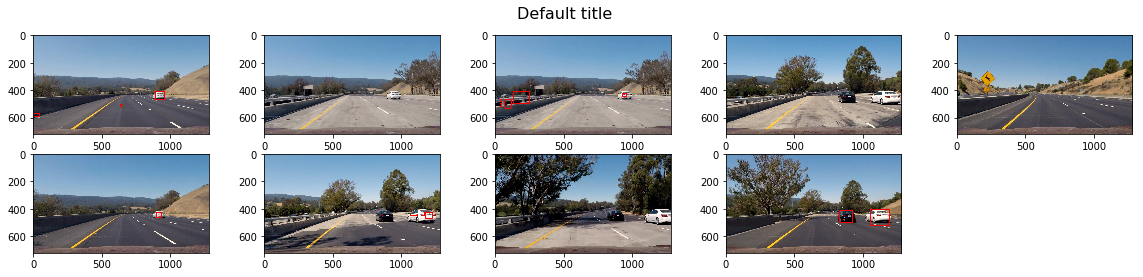

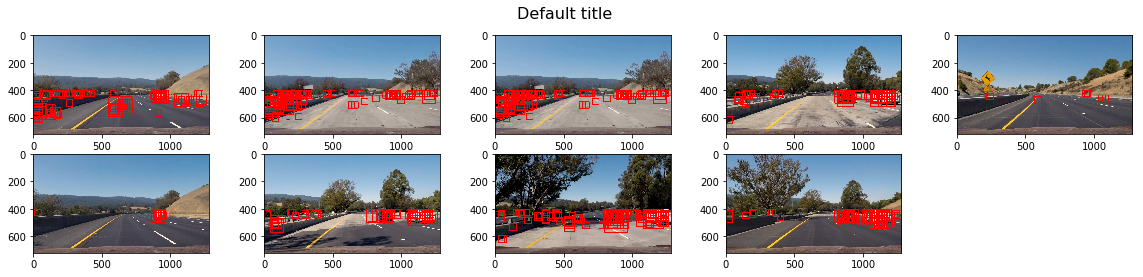

In [14]:
from scipy.ndimage.measurements import label


prev_n_bb_list_list = []

frames_since_last_reset = 0
min_detected_object_threshold = 2
num_frames_without_reset = 0
max_frames_without_reset = 15

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(images, ystart, ystop, scale, svc, X_scaler, orient, window_pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace='RGB',):
    global prev_n_bb_list_list 
    global frames_since_last_reset
    global min_detected_object_threshold
    global num_frames_without_reset
    global max_frames_without_reset
    heat_imgs = []
    draw_imgs = []
    
    for image in images:
        # Read in each one by one
        img = image
        draw_img = np.copy(img)
        heat_img = np.zeros_like(img[:,:,0]).astype(np.float)
        
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        else: feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   
    
        feature_image = feature_image.astype(np.float32)/255
                
        img_tosearch = feature_image[ystart:ystop,:,:]    
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
        
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
            
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
        
        
        for (window, pix_per_cell) in window_pix_per_cell:
            # Define blocks and steps as above
            nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
            nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
            nfeat_per_block = orient*cell_per_block**2
            
            # 64 was the original sampling rate, with 8 cells and 8 pix per cell
            #window = 64
            nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
            #print(nblocks_per_window)
            cells_per_step = 2  # Instead of overlap, define how many cells to step
            nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
            nysteps = (nyblocks - nblocks_per_window) // cells_per_step
            
            # Compute individual channel HOG features for the entire image
            hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
            
            for xb in range(nxsteps):
                for yb in range(nysteps):
                    ypos = yb*cells_per_step
                    xpos = xb*cells_per_step
                    # Extract HOG for this patch
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    #print(hog_feat1.shape)
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
        
                    xleft = xpos*pix_per_cell
                    ytop = ypos*pix_per_cell
        
                    # Extract the image patch
                    subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                  
                    # Get color features
                    spatial_features = bin_spatial(subimg, size=spatial_size)
                    hist_features = color_hist(subimg, nbins=hist_bins)
                            
                    # Scale features and make a prediction
                    all_features = np.hstack((spatial_features, hist_features, hog_features))
                    #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                    features = np.array([all_features]).astype(np.float64)
                    # Apply the scaler to X
                    #print(features.shape)
                    scaled_features = X_scaler.transform(features)
                    #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                    test_prediction = svc.predict(scaled_features)
                    
                    if test_prediction == 1:
                        xbox_left = np.int(xleft*scale)
                        ytop_draw = np.int(ytop*scale)
                        win_draw = np.int(window*scale)
                        cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                        heat_img[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
             
        # TODO: Decide this after implementing false pos rejection and analyzing draw_img video
        heat_img[heat_img <= 8] = 0   
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat_img, 0, 255) 
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        (heat_img, new_bb_list) = draw_labeled_bboxes(np.copy(img), labels, prev_n_bb_list_list)
        
        # Reset previous detections if less than min_detected_object_threshold objects were detected 
        # consecutively for more than max_frames_without_reset
        prev_n_bb_list_list = prev_n_bb_list_list[:len(prev_n_bb_list_list)-1] if len(new_bb_list) < 2 else [new_bb_list] + prev_n_bb_list_list[:7]
        
#         if len(new_bb_list) < min_detected_object_threshold:
#             num_frames_without_reset = num_frames_without_reset + 1
        
#         if num_frames_without_reset > max_frames_without_reset:
#             num_frames_without_reset = 0
#             prev_n_bb_list_list = []
       
        #show_images([draw_img])
            
        heat_imgs.append(heat_img)
        draw_imgs.append(draw_img)
    return (heat_imgs, draw_imgs)


ystart = 400
ystop = 656
scale = 1.5
window_pix_per_cell = [(32, 4), (48, 6), (64, 8), (80, 10), (96, 12), (112, 14)]

# Read in test images
test_images_generator = glob.iglob('./test_images/**/*.jpg', recursive=True)
test_images = []
for image in test_images_generator:
    #if image.startswith('./test_images/Screen'):
     if True:
        test_images.append(cv2.resize(cv2.imread(image), (1280, 720)))
    
(heat_imgs, draw_imgs) = find_cars(test_images, ystart, ystop, scale, svc, X_scaler, orient, window_pix_per_cell, cell_per_block, spatial_size, histbin, cspace=color_space)

show_images(heat_imgs, CMAP='hot')
show_images(draw_imgs)

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    (heat_imgs, draw_imgs) = find_cars([image], ystart, ystop, scale, svc, X_scaler, orient, window_pix_per_cell, cell_per_block, spatial_size, histbin, cspace=color_space)
    return heat_imgs[0]

output_path = 'output_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
project_video = VideoFileClip("project_video.mp4")\
#.subclip(5,8)
#.subclip(27,31)
project_clip = project_video.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(output_path, audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████▉| 1260/1261 [57:46<00:02,  2.73s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

CPU times: user 56min 19s, sys: 1min 22s, total: 57min 42s
Wall time: 57min 48s


In [5]:



HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path))